In [1]:
! gdown https://drive.google.com/u/0/uc?id=17WpSslT1bv81vHy3k1u0lo53_S10evDe

Downloading...
From: https://drive.google.com/u/0/uc?id=17WpSslT1bv81vHy3k1u0lo53_S10evDe
To: /content/CXR_Covid-19_Challenge.zip
3.61GB [00:55, 64.6MB/s]


In [2]:
! unzip -qq CXR_Covid-19_Challenge.zip

In [ ]:
# ! gdown https://drive.google.com/u/2/uc?id=1cpqqgbb77-1vt5-SvmQWV2Klla_tuLjD

In [3]:
import glob
import cv2
import matplotlib.pyplot as plt

###########################
EPOCHS = 10
MODEL_NAME = 'VGG_16'
IMG_SIZE = '360x360'
OUTPUT_LAYERS = '128-32-3'
###########################

In [4]:
all_covid_files = glob.glob('/content/train/covid/*')
all_normal_files = glob.glob('/content/train/normal/*')
all_pneumo_files = glob.glob('/content/train/pneumonia/*')
print(len(all_covid_files)," ",len(all_normal_files)," ",len(all_pneumo_files)," ")

6534   7151   4273  


In [ ]:
# plot it in histogram


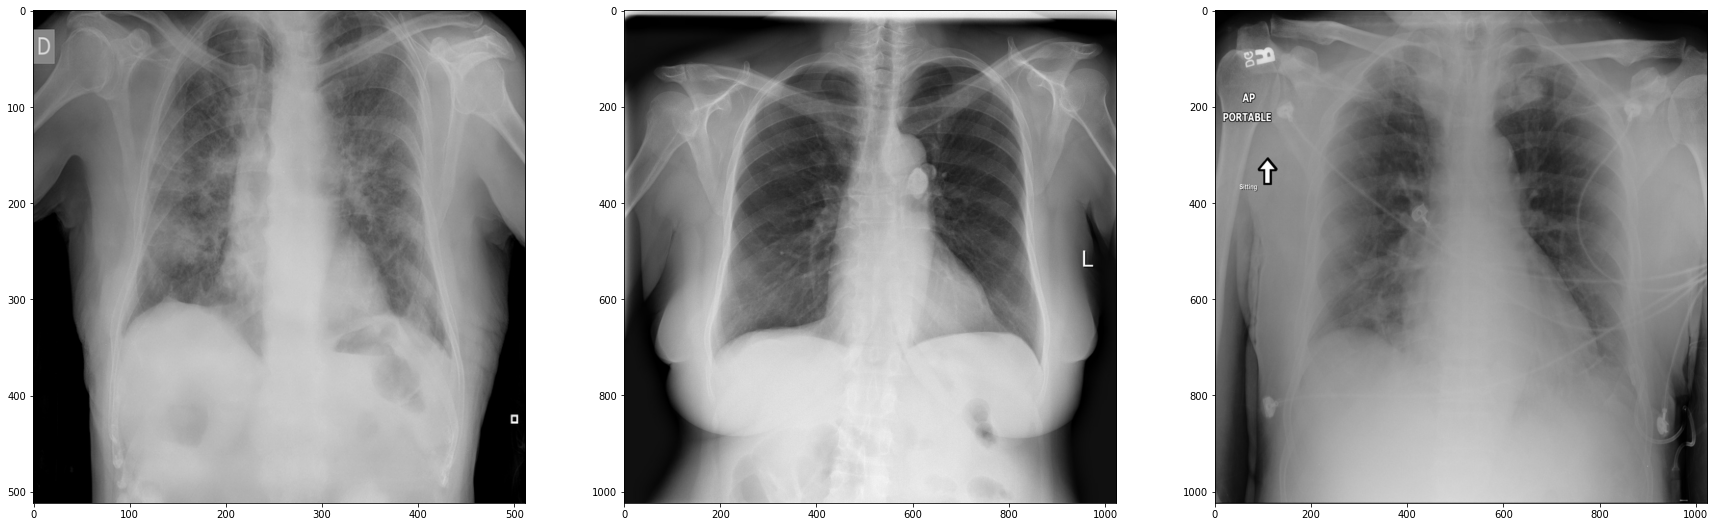

In [5]:

plt.figure(figsize=(30,10))
img_covid = cv2.imread(all_covid_files[0])
plt.subplot(1,3,1)
plt.imshow(img_covid)
img_normal = cv2.imread(all_normal_files[0])
plt.subplot(1,3,2)
plt.imshow(img_normal)
img_pneumo = cv2.imread(all_pneumo_files[0])
plt.subplot(1,3,3)
plt.imshow(img_pneumo)
plt.show()

In [6]:
print(img_pneumo.shape)
print(img_covid.shape)
print(img_normal.shape)

(1024, 1024, 3)
(512, 512, 3)
(1024, 1024, 3)


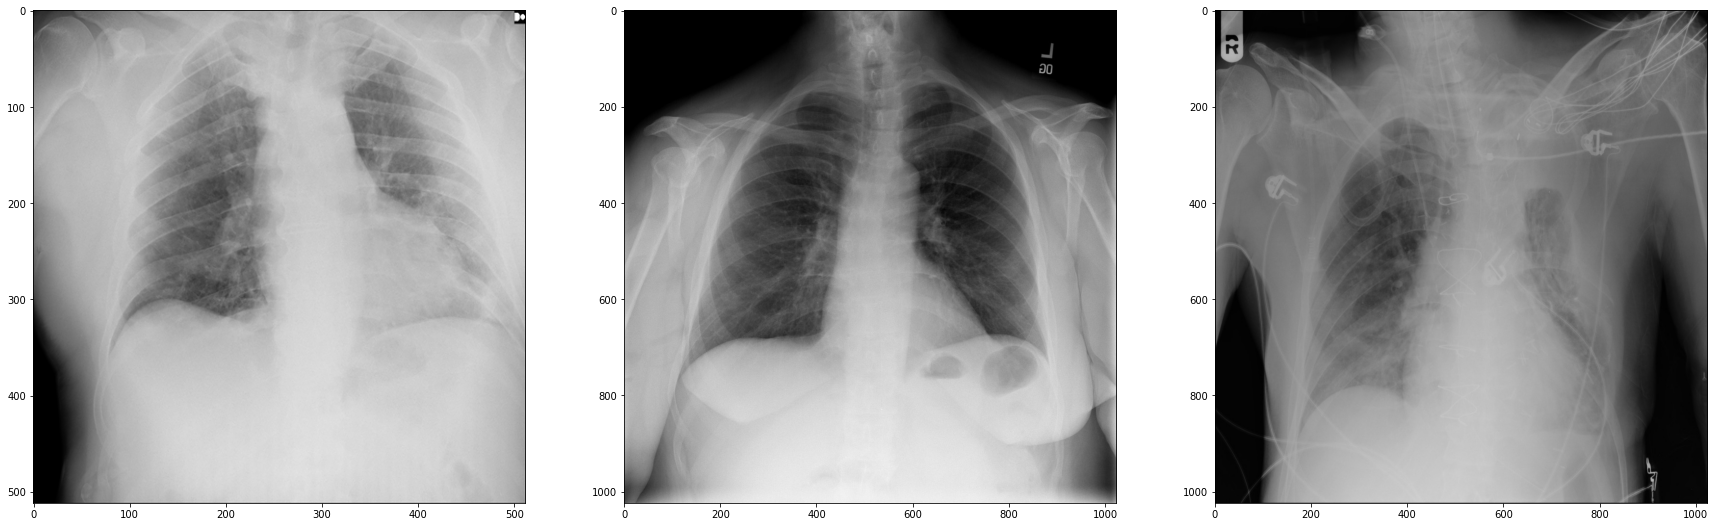

In [ ]:

plt.figure(figsize=(30,10))
img_covid = cv2.imread(all_covid_files[1])
plt.subplot(1,3,1)
plt.imshow(img_covid)
img_normal = cv2.imread(all_normal_files[1])
plt.subplot(1,3,2)
plt.imshow(img_normal)
img_pneumo = cv2.imread(all_pneumo_files[1])
plt.subplot(1,3,3)
plt.imshow(img_pneumo)
plt.show()

In [7]:


from tensorflow.keras.utils import to_categorical
from PIL import Image

import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import glob
import time
import cv2
import os
from tensorflow.keras.utils import to_categorical
from PIL import Image

import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D,\
                                    GlobalMaxPool2D, Dropout, SpatialDropout2D, add, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall, SensitivityAtSpecificity, PrecisionAtRecall, \
                                     TruePositives, TrueNegatives, FalsePositives, FalseNegatives


from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import glob
import time
import cv2
import os



In [8]:

dir = glob.glob('train/*')
get_freq = {}
# count = 1
for item in dir:
  freq = len(glob.glob("{}/*".format(item)))
  print(freq)
  item_name  = item.split('/')[1]
  get_freq[item_name] = freq
  #get_freq[count] = freq
  #count += 1
  #get_freq.append(freq)


4273
6534
7151


In [9]:
index = {'normal': 0, 'covid': 1,  'pneumonia': 2}
rev_index = {0: 'normal',1: 'covid', 2: 'pneumonia'}

In [10]:
def parse_filepath(filepath):
    try:
        #path, filename = os.path.split(filepath)
        label = filepath.split('/')[1]
        #filename, ext = os.path.splitext(filename)
        #label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [11]:
# np.random.seed(42)

H, W, C = 360, 360, 3
N_LABELS = len(index)
D = 1

files_train = glob.glob("train/*/*.*")
print("Total files train = ",len(files_train))


# create a pandas data frame of images, age, gender and race
attributes = list(map(parse_filepath, files_train))

df_train = pd.DataFrame(attributes)
df_train['file'] = files_train
df_train.columns = ['label', 'file']
df_train = df_train.dropna()
df_train.tail()


p = np.random.permutation(len(df_train))
train_idx = p[:len(df_train)]


Total files train =  17958


In [12]:
# for item in files_train:
#     if item.split('.')[-1] not in 'jpg' and item.split('.')[-1] not in 'png':
#         print(item)
#     # print(item.split('.')[-1])
#     # break

In [13]:

##################################
H, W, C = 360, 360, 3
N_LABELS = len(index)
D = 1
##################################

files_validation = glob.glob("validation/*/*.*")
print("Total files valid = ",len(files_validation))

# create a pandas data frame of images, age, gender and race
attributes = list(map(parse_filepath, files_validation))

df_val = pd.DataFrame(attributes)
df_val['file'] = files_validation
df_val.columns = ['label', 'file']
df_val = df_val.dropna()
df_val.tail()

print(len(df_val))
p = np.random.permutation(len(df_val))
test_idx = p[:len(df_val)]



Total files valid =  3432
3432


In [14]:
print('train count: %s,  test count: %s' % (
    len(train_idx),  len(test_idx)))


train count: 17958,  test count: 3432


In [15]:
# for item in files_validation:
#     if item.split('.')[-1] not in 'jpg' and item.split('.')[-1] not in 'png':
#         print(item)
#     # print(item.split('.')[-1])
#     # break

In [16]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten, GlobalAveragePooling2D


# Change the pretrained model name according to the given criteria

frozen = VGG16 (weights="imagenet", input_shape=(360,360,3), include_top=False)
frozen.summary()

trainable = frozen.output
trainable = GlobalAveragePooling2D()(trainable)
#print(trainable.shape)
trainable = Dense(128, activation="relu")(trainable)
trainable = Dense(32, activation="relu")(trainable)
trainable = Dense(N_LABELS, activation="softmax")(trainable)
model = Model(inputs=frozen.input, outputs=trainable)
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 360, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 360, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 180, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 180, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 180, 128)     147584    
______________________________________________________________

In [17]:

import tensorflow as tf
from tensorflow import keras
import keras
import keras.utils
from keras import utils as np_utils
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

# Display

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.utils import to_categorical
from PIL import Image
import numpy as np
import cv2
import glob


"""
## The Grad-CAM algorithm
"""


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        # print("shape = ", pred_index.shape)
        
        # print(pred_index)
        # plt.imshow(np.expand_dims(pred_index, axis=0))
        # print(preds.shape)
        class_channel = preds[:] 

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
    
def get_jet_img(img, heatmap):
    

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # save_path = "cell.jpg"
    # superimposed_img.save(save_path)
    # img_ = cv2.resize(img, (360, 360),interpolation=cv2.INTER_CUBIC)
    # print("img ","--"*60,img.shape)
    heatmap_ = cv2.resize(heatmap, (256, 256),interpolation = cv2.INTER_CUBIC)
    print("heatmap ","--"*60,heatmap.shape)
    print("heatmap_ ","--"*60,heatmap_.shape)
    superimposed_img_ = cv2.resize(np.array(superimposed_img), (256, 256),interpolation = cv2.INTER_CUBIC)
    print("superimposed img ","--"*60,np.array(superimposed_img).shape)
    # plt.show(superimposed_img)
    return img, heatmap, heatmap_, superimposed_img

In [18]:
# https://stackoverflow.com/questions/55640149/error-in-keras-when-i-want-to-calculate-the-sensitivity-and-specificity
# add specificity and sensitivity here
# https://datascience.stackexchange.com/questions/33587/keras-custom-loss-function-as-true-negatives-by-true-negatives-plus-false-posit/40746#40746
# add some loss functions here

# Metrics
# https://www.sabinasz.net/unbalanced-classes-machine-learning/

from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())



opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy',
            #experimental_run_tf_function=False,
            metrics = ['accuracy', sensitivity, specificity]
            )



In [19]:
# tf.keras.utils.plot_model(model, to_file='Model1.png')
# from IPython.display import Image
# Image(retina=True, filename='Model1.png')

In [20]:
# data generator function needs to be changed, i.e., preprocessing should be done first
# to avoid bottlenecks.

from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        # print("indices = ",indices)    
        # print("len indices = ",len(indices))
        for i in indices:
            r = df.iloc[i]
            # print(" r = ", r, " i = ",i)
            file, label = r['file'], r['label']
            # print("file, label = ",file, label)
            im_gray = Image.open(file).convert('L')
            # print("Shape = ",im_gray.shape)
            im_gray = im_gray.resize((360,360))
            im = np.zeros(shape=(360,360,3))
            
            im[:,:,0] = im_gray
            im[:,:,1] = im_gray
            im[:,:,2] = im_gray
            im = np.array(im) / 255.0

            # print(im.shape)
            images.append(im)
            # print(np.asarray([to_categorical(index[label], N_LABELS)]))
            # print(np.asarray([to_categorical(index[label], N_LABELS)]).shape)
            
            labels.append(to_categorical(index[label], N_LABELS))
            if len(images) >= batch_size:
                yield np.array(images), np.array(labels)
                images, labels = [], []
        # if not for_training:
        #     break


from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator_custom(df, indices, for_training, batch_size=16):
    labels = []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            labels.append(to_categorical(index[label], N_LABELS))
            if len(images) >= batch_size:
                yield  np.array(labels)
                labels = []


In [21]:


from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
# batch_size = 100
# valid_batch_size = 32
batch_size = 16
valid_batch_size = 16
train_gen = get_data_generator(df_train, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df_val, test_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss'),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)
]

# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [22]:

# history = model.fit(train_gen,
#                     steps_per_epoch=len(train_idx)//batch_size,
#                     epochs=5,
#                     callbacks=[tensorboard_callback,callbacks],
#                     validation_data=valid_gen,
#                     validation_steps=len(test_idx)//valid_batch_size)

In [23]:
# ! gdown https://drive.google.com/u/2/uc?id=1Ma8-7fG8-CneFcR0qBJ2aXNakKXyujqS
! gdown https://drive.google.com/u/0/uc?id=1_fWrH3qvkYhA8Y0j7DRMEf_xroE8WJBh

Downloading...
From: https://drive.google.com/u/0/uc?id=1_fWrH3qvkYhA8Y0j7DRMEf_xroE8WJBh
To: /content/CXR_Covid-19_100e_VGG_16_360x360_128-32-3.h5
178MB [00:02, 79.3MB/s]


In [24]:
from tensorflow import keras
model = keras.models.load_model('CXR_Covid-19_100e_VGG_16_360x360_128-32-3.h5', custom_objects={'specificity': specificity, 'sensitivity': sensitivity})

In [25]:
test_gen = get_data_generator(df_val, test_idx, for_training=False)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx))))

 121/3432 [>.............................] - ETA: 20:40 - loss: 0.6898 - accuracy: 0.9525 - sensitivity: 0.9525 - specificity: 0.9762

KeyboardInterrupt: ignored

In [26]:

from tensorflow.keras.utils import to_categorical
from PIL import Image
from tqdm import tqdm
y_pred_list = []
y_test_list = []

act_label_list = []
pred_label_list = []
list_file_name = []
all_pred = []

for i in tqdm(test_idx):
    r = df_val.iloc[i]
    file_, label = r['file'], r['label']

    im_gray = Image.open(file_).convert('L')
    im_gray = im_gray.resize((360,360))
    im = np.zeros(shape=(360,360,3))

    im[:,:,0] = im_gray
    im[:,:,1] = im_gray
    im[:,:,2] = im_gray
    im = np.array(im) / 255.0

    y_pred = model.predict(im[np.newaxis, ...])
    y_pred_list.append(int(tf.math.argmax(y_pred, axis=-1)))
    histogram = y_pred
    all_pred.append(histogram)
    
    pred_label = rev_index[int(tf.math.argmax(y_pred, axis=-1))]
    act_label_list.append(label)
    pred_label_list.append(pred_label)
    list_file_name.append(file_)
    y_test_list.append(index[label])

    
    

100%|██████████| 3432/3432 [07:31<00:00,  7.60it/s]


In [27]:
import pickle

with open('act_label_list_{}e_{}_{}_{}.pkl'.format(EPOCHS, MODEL_NAME,IMG_SIZE,OUTPUT_LAYERS), 'wb') as f:
    pickle.dump(act_label_list, f)
with open('pred_label_list_{}e_{}_{}_{}.pkl'.format(EPOCHS, MODEL_NAME,IMG_SIZE,OUTPUT_LAYERS), 'wb') as f:
    pickle.dump(pred_label_list, f)
with open('list_file_name_{}e_{}_{}_{}.pkl'.format(EPOCHS, MODEL_NAME,IMG_SIZE,OUTPUT_LAYERS), 'wb') as f:
    pickle.dump(list_file_name, f)

In [28]:
with open('act_label_list_{}e_{}_{}_{}.pkl'.format(EPOCHS, MODEL_NAME,IMG_SIZE,OUTPUT_LAYERS), 'rb') as f:
    act_label_list = pickle.load(f)
with open('pred_label_list_{}e_{}_{}_{}.pkl'.format(EPOCHS, MODEL_NAME,IMG_SIZE,OUTPUT_LAYERS), 'rb') as f:
    pred_label_list = pickle.load(f)
with open('list_file_name_{}e_{}_{}_{}.pkl'.format(EPOCHS, MODEL_NAME,IMG_SIZE,OUTPUT_LAYERS), 'rb') as f:
    list_file_name = pickle.load(f)

In [29]:
print(len(pred_label_list),len(act_label_list),len(list_file_name))

3432 3432 3432


In [30]:
pred_label_list[:10]

['normal',
 'covid',
 'normal',
 'normal',
 'normal',
 'normal',
 'covid',
 'covid',
 'covid',
 'pneumonia']

In [31]:
act_label_list[:10]

['normal',
 'covid',
 'normal',
 'normal',
 'pneumonia',
 'normal',
 'covid',
 'covid',
 'covid',
 'pneumonia']

In [32]:
list_file_name[:10]

['validation/normal/norml_333.png',
 'validation/covid/cov_517.png',
 'validation/normal/norml_607.png',
 'validation/normal/norml_899.png',
 'validation/pneumonia/pneu_613.png',
 'validation/normal/norml_780.png',
 'validation/covid/cov_615.png',
 'validation/covid/cov_559.png',
 'validation/covid/cov_863.png',
 'validation/pneumonia/pneu_522.png']

In [33]:
all_pred[:10]

[array([[1.0000000e+00, 5.9051325e-22, 7.3616777e-16]], dtype=float32),
 array([[5.6513597e-21, 1.0000000e+00, 6.3725809e-16]], dtype=float32),
 array([[1.0000000e+00, 2.4572961e-18, 3.2110818e-13]], dtype=float32),
 array([[1.0000000e+00, 1.3790059e-20, 2.1263308e-16]], dtype=float32),
 array([[1.0000000e+00, 1.4019105e-25, 5.9502953e-20]], dtype=float32),
 array([[1.0000000e+00, 9.7913212e-18, 2.9177743e-20]], dtype=float32),
 array([[4.2904493e-13, 1.0000000e+00, 3.1726934e-19]], dtype=float32),
 array([[1.3995181e-23, 1.0000000e+00, 5.0164081e-20]], dtype=float32),
 array([[0., 1., 0.]], dtype=float32),
 array([[1.05725755e-32, 1.30818321e-21, 1.00000000e+00]], dtype=float32)]

validation/covid/cov_750.png
[[4.3006360e-21 2.9460102e-04 9.9970537e-01]]
(45, 45)


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


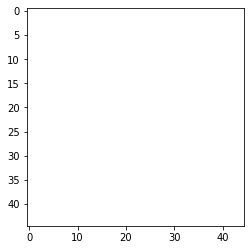

validation/covid/cov_201.png
[[2.1874209e-28 2.3200859e-05 9.9997675e-01]]
(45, 45)


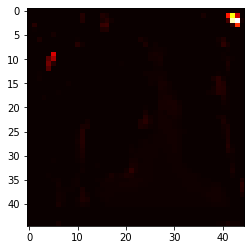

validation/covid/cov_111669.jpg
[[4.7832859e-08 1.0590448e-01 8.9409554e-01]]
(45, 45)


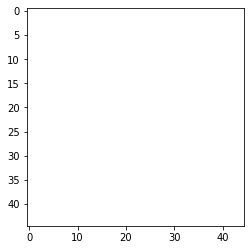

validation/covid/cov_111727.jpg
[[3.1785069e-35 1.3424323e-15 1.0000000e+00]]
(45, 45)


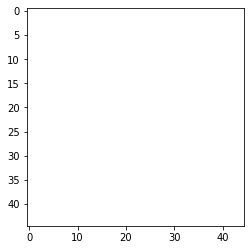

validation/covid/cov_111686.jpg
[[8.9343395e-14 4.8197765e-02 9.5180219e-01]]
(45, 45)


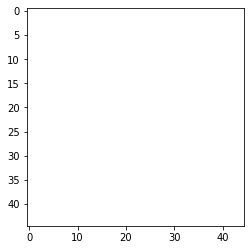

validation/covid/cov_111679.jpg
[[2.9582764e-20 3.0584136e-04 9.9969423e-01]]
(45, 45)


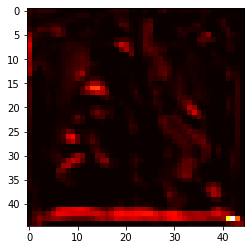

validation/covid/cov_1114.png
[[2.7164729e-11 3.8764692e-06 9.9999607e-01]]
(45, 45)


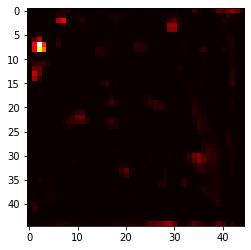

validation/covid/cov_541.png
[[9.0264348e-22 4.5823656e-14 1.0000000e+00]]
(45, 45)


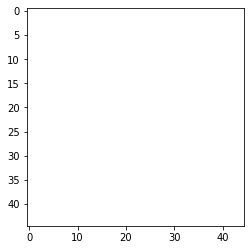

In [50]:
last_conv_layer_name = 'block4_conv3'


c = 0

for pred, actual, list_name in zip(pred_label_list, act_label_list, list_file_name):
    print("======================================================================")
    if actual == 'covid' and pred == 'pneumonia':
        c += 1
        if c > 200:
            break
        print(list_name)
        file_name = list_name.split('.')[0]
        im_gray = Image.open(list_name).convert('L')
        im_gray = im_gray.resize((360,360))
        im = np.zeros(shape=(360,360,3))

        im[:,:,0] = im_gray
        im[:,:,1] = im_gray
        im[:,:,2] = im_gray
        im = np.array(im) / 255.0

        y_pred = model.predict(im[np.newaxis, ...])
        y_pred_list.append(int(tf.math.argmax(y_pred, axis=-1)))
        histogram = y_pred

        pred_label = rev_index[int(tf.math.argmax(y_pred, axis=-1))]

        y_test_list.append(index[label])
        heat_map = make_gradcam_heatmap(im[np.newaxis, ...], model, last_conv_layer_name, pred_index=None)
        print(histogram)
        im_gray_cv2 = cv2.imread(file_,cv2.IMREAD_GRAYSCALE)
        # print(im_gray_cv2.shape)
        # print(heat_map.shape)
        heat_map = heat_map/heat_map.max()

        print(heat_map.shape)
        # save the heatmap
        plt.imshow(heat_map,cmap='hot')
        plt.show()

        # inp = input("Save image = ? (y/N)")
        # if inp == 'y' or inp == 'Y':
        #     print("Saved")
        #     heat_map_save_name = file_name+"_"+last_conv_layer_name+"_heatmap"+".npy"
        #     np.save(heat_map_save_name, heat_map)    # .npy extension is added if not given
    print("======================================================================")



In [51]:
# Actual = Covid -> Pred = covid

! cp validation/covid/cov_322.png .
# [[6.4819908e-08 9.9999988e-01 4.9942143e-15]]

! cp validation/covid/cov_111665.jpg .
# [[4.899920e-21 9.999999e-01 8.640558e-08]]


# Covid > Normal

! cp validation/covid/cov_1056.png .
# [[9.9995697e-01 3.9018854e-05 4.0789382e-06]]



# Covid > Pneumonia

! cp validation/covid/cov_201.png .
# [[2.1874209e-28 2.3200859e-05 9.9997675e-01]]

! cp validation/covid/cov_111679.jpg .
# [[2.9582764e-20 3.0584136e-04 9.9969423e-01]]

! cp validation/covid/cov_1114.png .
# [[2.7164729e-11 3.8764692e-06 9.9999607e-01]]


In [ ]:
# ! mv validation/covid/cov_25.png .

In [ ]:
# make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None)

In [54]:
all_files = glob.glob('*.jpg')
all_files

['cov_111665.jpg', 'cov_111679.jpg']

In [55]:
# block1_conv1 (3, 3, 3, 64)
# block1_conv2 (3, 3, 64, 64)
# block2_conv1 (3, 3, 64, 128)
# block2_conv2 (3, 3, 128, 128)
# block3_conv1 (3, 3, 128, 256)
# block3_conv2 (3, 3, 256, 256)
# block3_conv3 (3, 3, 256, 256)
# block4_conv1 (3, 3, 256, 512)
# block4_conv2 (3, 3, 512, 512)
# block4_conv3 (3, 3, 512, 512)
# block5_conv1 (3, 3, 512, 512)
# block5_conv2 (3, 3, 512, 512)
# block5_conv3 (3, 3, 512, 512)

(497, 679)
(360, 360)
(360, 360)


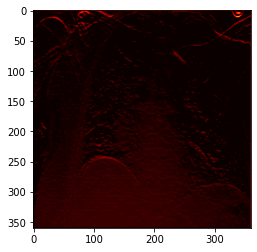

(2200, 2200)
(360, 360)
(360, 360)


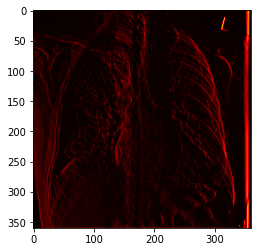

(497, 679)
(360, 360)
(360, 360)


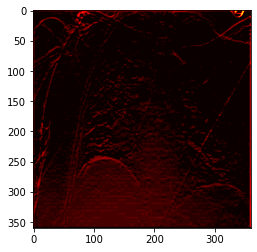

(2200, 2200)
(360, 360)
(360, 360)


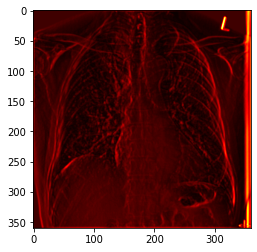

(497, 679)
(180, 180)
(180, 180)


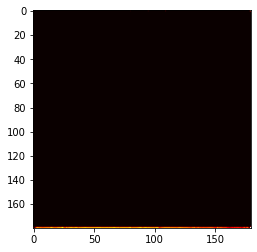

(2200, 2200)
(180, 180)
(180, 180)


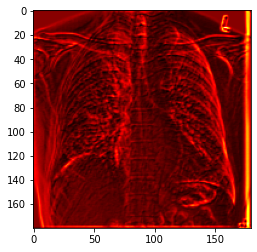

(497, 679)
(180, 180)
(180, 180)


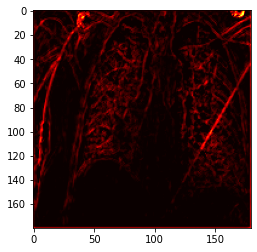

(2200, 2200)
(180, 180)
(180, 180)


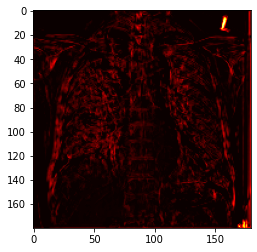

(497, 679)
(90, 90)
(90, 90)


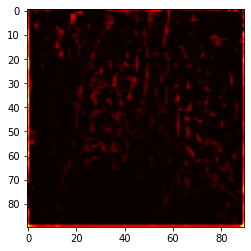

(2200, 2200)
(90, 90)
(90, 90)


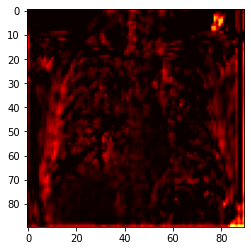

(497, 679)
(90, 90)
(90, 90)


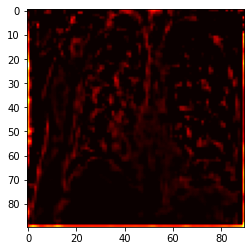

(2200, 2200)
(90, 90)
(90, 90)


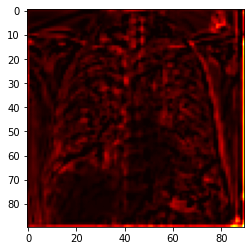

(497, 679)
(90, 90)
(90, 90)


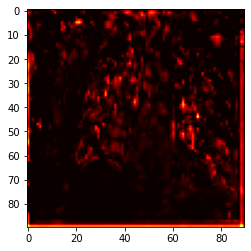

(2200, 2200)
(90, 90)
(90, 90)


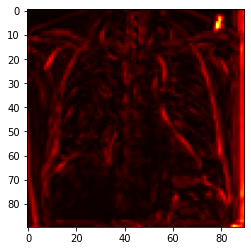

(497, 679)
(45, 45)
(45, 45)


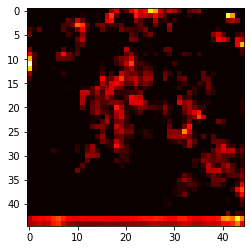

(2200, 2200)
(45, 45)
(45, 45)


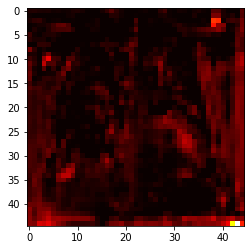

(497, 679)
(45, 45)
(45, 45)


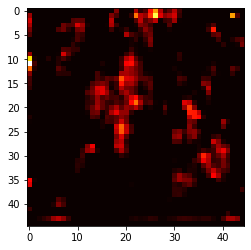

(2200, 2200)
(45, 45)
(45, 45)


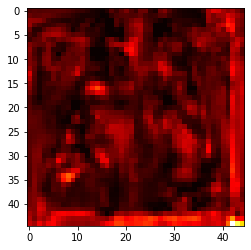

(497, 679)
(45, 45)
(45, 45)


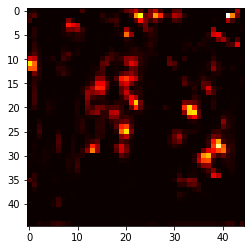

(2200, 2200)
(45, 45)
(45, 45)


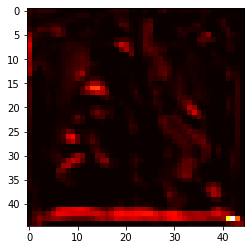

(497, 679)
(22, 22)
(22, 22)


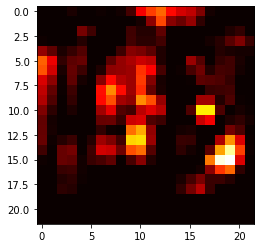

(2200, 2200)
(22, 22)
(22, 22)


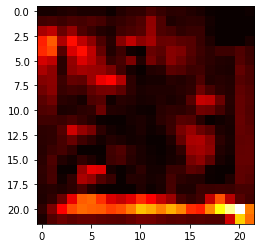

(497, 679)
(22, 22)
(22, 22)


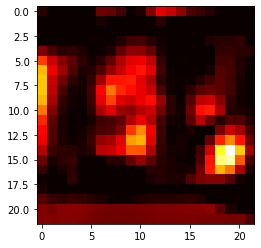

(2200, 2200)
(22, 22)
(22, 22)


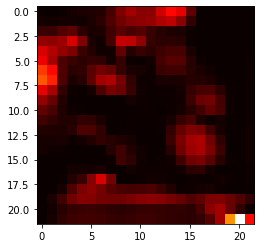

(497, 679)
(22, 22)
(22, 22)


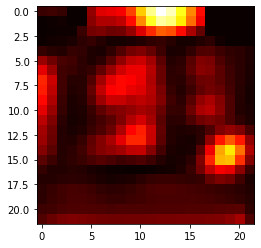

(2200, 2200)
(22, 22)
(22, 22)


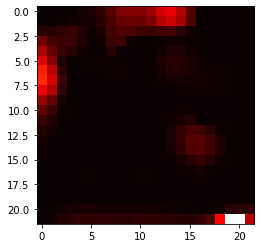

In [56]:
last_conv_layer_names = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2',
                         'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 
                         'block5_conv3']


for last_conv_layer_name in last_conv_layer_names:
    for file_ in all_files:
        file_name = file_.split('.')[0]
        im_gray = Image.open(file_).convert('L')
        im_gray = im_gray.resize((360,360))
        im = np.zeros(shape=(360,360,3))

        im[:,:,0] = im_gray
        im[:,:,1] = im_gray
        im[:,:,2] = im_gray
        im = np.array(im) / 255.0

        y_pred = model.predict(im[np.newaxis, ...])
        y_pred_list.append(int(tf.math.argmax(y_pred, axis=-1)))
        histogram = y_pred

        pred_label = rev_index[int(tf.math.argmax(y_pred, axis=-1))]

        y_test_list.append(index[label])
        heat_map = make_gradcam_heatmap(im[np.newaxis, ...], model, last_conv_layer_name, pred_index=None)
        im_gray_cv2 = cv2.imread(file_,cv2.IMREAD_GRAYSCALE)
        print(im_gray_cv2.shape)
        print(heat_map.shape)
        heat_map = heat_map/heat_map.max()
        print(heat_map.shape)
        # save the heatmap
        plt.imshow(heat_map,cmap='hot')
        plt.show()
        
        heat_map_save_name = file_name+"_"+last_conv_layer_name+"_heatmap"+".npy"
        np.save(heat_map_save_name, heat_map)    # .npy extension is added if not given
        


In [45]:
! rm -rf *.jpg

In [57]:
! mkdir npy_files

In [58]:
! mv *.npy npy_files

In [59]:
! zip -r npy_files.zip npy_files

  adding: npy_files/ (stored 0%)
  adding: npy_files/cov_1114_block1_conv1_heatmap.npy (deflated 83%)
  adding: npy_files/cov_322_block2_conv1_heatmap.npy (deflated 99%)
  adding: npy_files/cov_1056_block4_conv1_heatmap.npy (deflated 34%)
  adding: npy_files/cov_111679_block4_conv1_heatmap.npy (deflated 29%)
  adding: npy_files/cov_1056_block1_conv1_heatmap.npy (deflated 39%)
  adding: npy_files/cov_322_block3_conv2_heatmap.npy (deflated 88%)
  adding: npy_files/cov_111665_block3_conv1_heatmap.npy (deflated 64%)
  adding: npy_files/cov_111679_block5_conv1_heatmap.npy (deflated 12%)
  adding: npy_files/cov_111665_block2_conv1_heatmap.npy (deflated 99%)
  adding: npy_files/cov_322_block4_conv1_heatmap.npy (deflated 97%)
  adding: npy_files/cov_1056_block4_conv2_heatmap.npy (deflated 74%)
  adding: npy_files/cov_1114_block4_conv1_heatmap.npy (deflated 74%)
  adding: npy_files/cov_1056_block5_conv3_heatmap.npy (deflated 56%)
  adding: npy_files/cov_201_block3_conv1_heatmap.npy (deflated 43